In [4]:
!pip install -q sdv diffprivlib
!pip install torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2 torchtext==0.17.2
!pip install opacus==0.14.0
!pip install smartnoise-synth==1.0.5

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata

from sdv.evaluation.single_table import run_diagnostic
from sdv.evaluation.single_table import evaluate_quality

from diffprivlib.mechanisms import Laplace
from sdv.evaluation.single_table import evaluate_quality, run_diagnostic, get_column_plot

from xgboost import XGBClassifier
import joblib
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report


**CARICAMENTO DEL DATASET E SUDDIVISIONE IN TRAIN E HOLDOUT**

In [5]:
def carica_dataset():
    url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
    df = pd.read_csv(url, header=None)
    df.columns = ['pregnancies', 'glucose', 'blood_pressure', 'skin_thickness',
                  'insulin', 'bmi', 'diabetes_pedigree', 'age', 'outcome']
    print("Dataset caricato da GitHub")
    return df

def preprocessa_dataset(df):
    # Le colonne dove 0 è probabile indicatore di dato mancante
    cols_missing = ['glucose', 'blood_pressure', 'skin_thickness', 'insulin', 'bmi']

    # Sostituisci 0 con NaN in queste colonne specifiche
    df[cols_missing] = df[cols_missing].replace(0, np.nan)

    # Riempimento NaN con mediana colonna
    df[cols_missing] = df[cols_missing].fillna(df[cols_missing].median())

    # Controllo completo e eventuale ulteriore riempimento per NaN residui in tutto il dataframe
    df = df.fillna(df.median())

    # Optional: verifica se qualche colonna ha valori costanti
    for col in df.columns:
        if df[col].nunique() <= 1:
            print(f"Attenzione: la colonna {col} è costante o quasi.")

    return df

"""
def preprocessa_dataset(df):
    cols_missing = ['glucose', 'blood_pressure', 'skin_thickness', 'insulin', 'bmi']
    df[cols_missing] = df[cols_missing].replace(0, np.nan)
    df[cols_missing] = df[cols_missing].fillna(df[cols_missing].median())
    return df
"""
df = carica_dataset()
df = preprocessa_dataset(df)

# Suddivide il dataset in train (70%) e holdout (30%)
train_df, holdout_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['outcome'])

# Salva i due dataset in CSV separati
train_df.to_csv('dataset/real/diabetes_train.csv', index=False)
holdout_df.to_csv('dataset/real/diabetes_holdout.csv', index=False)

print(f"Dimensione train: {train_df.shape}")
print(f"Dimensione holdout: {holdout_df.shape}")

Dataset caricato da GitHub
Dimensione train: (537, 9)
Dimensione holdout: (231, 9)


**GENERAZIONE DATI SINTETICI (NO PRIVACY)**

In [25]:
# GENERAZIONE DATI SINTETICI (NO PRIVACY) NOE
def synthetic_no_privacy(df):
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(df)
    # Crea e addestra il modello CTGAN
    model = CTGANSynthesizer(
        metadata,
        epochs=2000,
        batch_size=100,
        generator_dim=(256, 256, 256),
        discriminator_dim=(256, 256),
        verbose=True
    )
    model.fit(df)
    # Genera dati sintetici
    synthetic= model.sample(num_rows=len(df))
    return synthetic, metadata

synthetic_noprivacy, metadata_noprivacy = synthetic_no_privacy(train_df)
synthetic_noprivacy.to_csv('dataset/synthetic/synthetic_no_privacy.csv', index=False)

/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/ctgan/synthesizers/_utils.py:16: FutureWarning: `cuda` parameter is deprecated and will be removed in a future release. Please use `enable_gpu` instead.
  warnings.warn(
Gen. (-3.80) | Discrim. (-0.10): 100%|██████████| 2000/2000 [04:17<00:00,  7.77it/s]


In [38]:
import pandas as pd
from snsynth import Synthesizer
from sklearn.preprocessing import MinMaxScaler

"""
QUESTO SAREBBE DI BASE, PERO' HO CERCATO DI MIGLIORARLO UN PO'
def synthetic_dp_dpctgan(df, epsilon):
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(data=df)
    continuous_cols = ['pregnancies','age','glucose','blood_pressure',
                   'skin_thickness','insulin','bmi','diabetes_pedigree']
    categorical_cols = ['outcome']
    synth = Synthesizer.create("dpctgan", epsilon=epsilon, verbose=True, epochs=500)
    synth.fit(df, continuous_columns=continuous_cols,
              categorical_columns=categorical_cols,
              preprocessor_eps=1.0)

    df_synt = synth.sample(len(df))
    return df_synt, metadata

# Genera sintetico con privacy moderata
synthetic_mod, metadata_mod = synthetic_dp_dpctgan(train_df, epsilon=6.0)
synthetic_mod.to_csv("dataset/synthetic/synthetic_dpctgan_mod.csv", index=False)

# Genera sintetico con privacy forte
synthetic_strong, metadata_strong = synthetic_dp_dpctgan(train_df, epsilon=2.0)
synthetic_strong.to_csv("dataset/synthetic/synthetic_dpctgan_strong.csv", index=False)
"""

# Definizione colonne continue e categoriche
continuous_cols = ['pregnancies','age','glucose','blood_pressure',
                   'skin_thickness','insulin','bmi','diabetes_pedigree']
categorical_cols = ['outcome']

def clip_outliers(df, cont_cols, lower_q=0.01, upper_q=0.99):
    df = df.copy()
    for col in cont_cols:
        low = df[col].quantile(lower_q)
        high = df[col].quantile(upper_q)
        df[col] = df[col].clip(low, high)
    return df

train_processed = clip_outliers(train_df.copy(), continuous_cols)
scaler = MinMaxScaler()
train_processed[continuous_cols] = scaler.fit_transform(train_processed[continuous_cols])

def generate_synthetic_privacy(df_class, n_samples, epsilon):
    #batch_size = min(64, len(df_class))  # batch_size <= dimensione dataset
    #synth = Synthesizer.create("dpctgan", epsilon=epsilon, verbose=True, epochs=500, batch_size=batch_size)

    batch_size = min(50, len(df_class) - len(df_class) % 10)  # multiplo di 10 = pac default
    synth = Synthesizer.create(
        "dpctgan",
        epsilon=epsilon,
        verbose=True,
        epochs=1500,
        batch_size=batch_size,
        generator_dim=[512, 256],
        discriminator_dim=[256, 128]
    )
    synth.fit(df_class,
              continuous_columns=continuous_cols,
              categorical_columns=categorical_cols,
              preprocessor_eps=1.0)
    synth_data = synth.sample(n_samples)

    # Opzionale: clipping post-generazione per correggere valori anomali
    synth_data[continuous_cols] = synth_data[continuous_cols].clip(lower=0, upper=1)

    return synth_data

n_total = len(train_processed)
n_class0 = n_total // 2
n_class1 = n_total - n_class0

# Generazione dataset sintetico privacy MODERATA per ciascuna classe
synthetic_0_mod = generate_synthetic_privacy(train_processed[train_processed['outcome']==0], n_class0, epsilon=6.0)
synthetic_1_mod = generate_synthetic_privacy(train_processed[train_processed['outcome']==1], n_class1, epsilon=6.0)

synthetic_mod = pd.concat([synthetic_0_mod, synthetic_1_mod], ignore_index=True)
synthetic_mod[continuous_cols] = scaler.inverse_transform(synthetic_mod[continuous_cols])
synthetic_mod.to_csv("dataset/synthetic/synthetic_privacy_moderata.csv", index=False)

# Metadata
metadata_mod = SingleTableMetadata()
metadata_mod.detect_from_dataframe(data=synthetic_mod)

# Generazione dataset sintetico privacy STRONG per ciascuna classe
synthetic_0_strong = generate_synthetic_privacy(train_processed[train_processed['outcome']==0], n_class0, epsilon=2.0)
synthetic_1_strong = generate_synthetic_privacy(train_processed[train_processed['outcome']==1], n_class1, epsilon=2.0)

synthetic_strong = pd.concat([synthetic_0_strong, synthetic_1_strong], ignore_index=True)
synthetic_strong[continuous_cols] = scaler.inverse_transform(synthetic_strong[continuous_cols])
synthetic_strong.to_csv("dataset/synthetic/synthetic_privacy_moderata.csv", index=False)
# Metadata
metadata_strong = SingleTableMetadata()
metadata_strong.detect_from_dataframe(data=synthetic_strong)


Spent 1.0 epsilon on preprocessor, leaving 5.0 for training


/usr/local/lib/python3.12/dist-packages/opacus/privacy_engine.py:638: UserWarning: The sample rate will be defined from ``batch_size`` and ``sample_size``.The returned privacy budget will be incorrect.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/opacus/privacy_engine.py:229: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 1, Loss G: 0.7181, Loss D: 1.4096
epsilon is 0.058899094223456495, alpha is 63.0
Epoch 2, Loss G: 0.7162, Loss D: 1.4072
epsilon is 0.35453384401892285, alpha is 27.0
Epoch 3, Loss G: 0.6923, Loss D: 1.3837
epsilon is 0.5098427941261138, alpha is 21.0
Epoch 4, Loss G: 0.7018, Loss D: 1.4364
epsilon is 0.6327043332327217, alpha is 18.0
Epoch 5, Loss G: 0.6860, Loss D: 1.4175
epsilon is 0.7383185749303754, alpha is 16.0
Epoch 6, Loss G: 0.7104, Loss D: 1.4124
epsilon is 0.8334737098456252, alpha is 14.0
Epoch 7, Loss G: 0.7276, Loss D: 1.4075
epsilon is 0.9201238570944299, alpha is 13.0
Epoch 8, Loss G: 0.6976, Loss D: 1.4292
epsilon is 1.0004023071354293, alpha is 13.0
Epoch 9, Loss G: 0.6893, Loss D: 1.4372
epsilon is 1.0754752234703093, alpha is 12.0
Epoch 10, Loss G: 0.6916, Loss D: 1.4134
epsilon is 1.1489274936996647, alpha is 10.9
Epoch 11, Loss G: 0.7027, Loss D: 1.3916
epsilon is 1.2154696122504238, alpha is 10.9
Epoch 12, Loss G: 0.6992, Loss D: 1.4126
epsilon is 1.280919

/usr/local/lib/python3.12/dist-packages/opacus/privacy_engine.py:638: UserWarning: The sample rate will be defined from ``batch_size`` and ``sample_size``.The returned privacy budget will be incorrect.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/opacus/privacy_engine.py:229: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 3, Loss G: 0.7064, Loss D: 1.4278
epsilon is 0.5897361924582399, alpha is 16.0
Epoch 4, Loss G: 0.7134, Loss D: 1.4052
epsilon is 0.7335031292371612, alpha is 14.0
Epoch 5, Loss G: 0.6948, Loss D: 1.4157
epsilon is 0.8571534751681066, alpha is 12.0
Epoch 6, Loss G: 0.6948, Loss D: 1.4277
epsilon is 0.9685641114284981, alpha is 10.9
Epoch 7, Loss G: 0.6870, Loss D: 1.4476
epsilon is 1.0698365162201269, alpha is 10.5
Epoch 8, Loss G: 0.6630, Loss D: 1.4375
epsilon is 1.1647519393121457, alpha is 9.8
Epoch 9, Loss G: 0.6928, Loss D: 1.4361
epsilon is 1.2541022644652147, alpha is 9.4
Epoch 10, Loss G: 0.7055, Loss D: 1.4313
epsilon is 1.3388718028599058, alpha is 8.9
Epoch 11, Loss G: 0.6759, Loss D: 1.4401
epsilon is 1.4197936084564775, alpha is 8.6
Epoch 12, Loss G: 0.6850, Loss D: 1.4340
epsilon is 1.4974404075866032, alpha is 8.3
Epoch 13, Loss G: 0.7029, Loss D: 1.4175
epsilon is 1.5721970536351395, alpha is 8.0
Epoch 14, Loss G: 0.6932, Loss D: 1.3968
epsilon is 1.6444891918509

/usr/local/lib/python3.12/dist-packages/opacus/privacy_engine.py:638: UserWarning: The sample rate will be defined from ``batch_size`` and ``sample_size``.The returned privacy budget will be incorrect.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/opacus/privacy_engine.py:229: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 2, Loss G: 0.7060, Loss D: 1.3992
epsilon is 0.35453384401892285, alpha is 27.0
Epoch 3, Loss G: 0.6943, Loss D: 1.4087
epsilon is 0.5098427941261138, alpha is 21.0
Epoch 4, Loss G: 0.6611, Loss D: 1.4147
epsilon is 0.6327043332327217, alpha is 18.0
Epoch 5, Loss G: 0.7000, Loss D: 1.4264
epsilon is 0.7383185749303754, alpha is 16.0
Epoch 6, Loss G: 0.6944, Loss D: 1.4166
epsilon is 0.8334737098456252, alpha is 14.0
Epoch 7, Loss G: 0.6844, Loss D: 1.4130
epsilon is 0.9201238570944299, alpha is 13.0
Spent 1.0 epsilon on preprocessor, leaving 1.0 for training
Epoch 1, Loss G: 0.7107, Loss D: 1.4088
epsilon is 0.0437339844421128, alpha is 63.0
Epoch 2, Loss G: 0.7031, Loss D: 1.4005
epsilon is 0.4091953640398871, alpha is 21.0


/usr/local/lib/python3.12/dist-packages/opacus/privacy_engine.py:638: UserWarning: The sample rate will be defined from ``batch_size`` and ``sample_size``.The returned privacy budget will be incorrect.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/opacus/privacy_engine.py:229: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 3, Loss G: 0.6912, Loss D: 1.4326
epsilon is 0.5897361924582399, alpha is 16.0
Epoch 4, Loss G: 0.7028, Loss D: 1.4307
epsilon is 0.7335031292371612, alpha is 14.0
Epoch 5, Loss G: 0.7023, Loss D: 1.4362
epsilon is 0.8571534751681066, alpha is 12.0
Epoch 6, Loss G: 0.6917, Loss D: 1.4328
epsilon is 0.9685641114284981, alpha is 10.9


**VALUTAZIONE SOMIGLIANZA STATISTICA**

ANALISI QUALITA' DEI DATI SINTETICI

In [26]:
def valuta_qualita_dataset(real, synth, metadata, nome=""):
    print(f"\n===== ANALISI QUALITÀ: {nome} =====")

    # 1) DIAGNOSTICA
    print("\n--- Diagnostic Report ---")
    diagnostic = run_diagnostic(
        real_data=real,
        synthetic_data=synth,
        metadata=metadata
    )

    # 2) QUALITY REPORT
    quality_report = evaluate_quality(
        real_data=real,
        synthetic_data=synth,
        metadata=metadata,
        verbose=False
    )
    print("\n--- Quality Score ---")
    print(quality_report.get_score())

    return diagnostic, quality_report

datasets_sintetici = [
    ("NO PRIVACY", synthetic_noprivacy, metadata_noprivacy),
    ("PRIVACY MODERATA", synthetic_mod, metadata_mod),
    ("PRIVACY STRONG", synthetic_strong, metadata_strong)
]

diagnostics = {}
quality_reports = {}

for nome, synth_df, meta in datasets_sintetici:
    diag, q_report = valuta_qualita_dataset(df, synth_df, meta, nome)
    diagnostics[nome] = diag
    quality_reports[nome] = q_report



===== ANALISI QUALITÀ: NO PRIVACY =====

--- Diagnostic Report ---
Generating report ...

(1/2) Evaluating Data Validity: |██████████| 9/9 [00:00<00:00, 834.43it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 255.21it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%


--- Quality Score ---
0.8669106340367325

===== ANALISI QUALITÀ: PRIVACY MODERATA =====

--- Diagnostic Report ---
Generating report ...

(1/2) Evaluating Data Validity: |██████████| 9/9 [00:00<00:00, 792.76it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 260.18it/s]|
Data Structure Score: 5.88%

Overall Score (Average): 52.94%


--- Quality Score ---
0.6364895781228257

===== ANALISI QUALITÀ: PRIVACY STRONG =====

--- Diagnostic Report ---
Generating report ...

(1/2) Evaluating Data Validity: |██████████| 9/9 [00:00<00:00, 932.90it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |█████

ANALISI SOMIGLIANZA STATISTICA DEI DATI SINTETICI


===== ANALISI SOMIGLIANZA STATISTICA: NO PRIVACY =====

Confronto delle medie tra reale e sintetico:
Feature                         Mean Real   Mean Synthetic         Diff
pregnancies                        3.8451           4.1173       0.2723
glucose                          121.6562         131.3687       9.7125
blood_pressure                    72.3867          68.2142      -4.1726
skin_thickness                    29.1081          32.6331       3.5251
insulin                          140.6719         124.2588     -16.4130
bmi                               32.4552          31.4048      -1.0504
diabetes_pedigree                  0.4719           0.4514      -0.0205
age                               33.2409          36.5289       3.2880
outcome                            0.3490           0.4749       0.1259

Confronto MATRICE DI CORRELAZIONE:


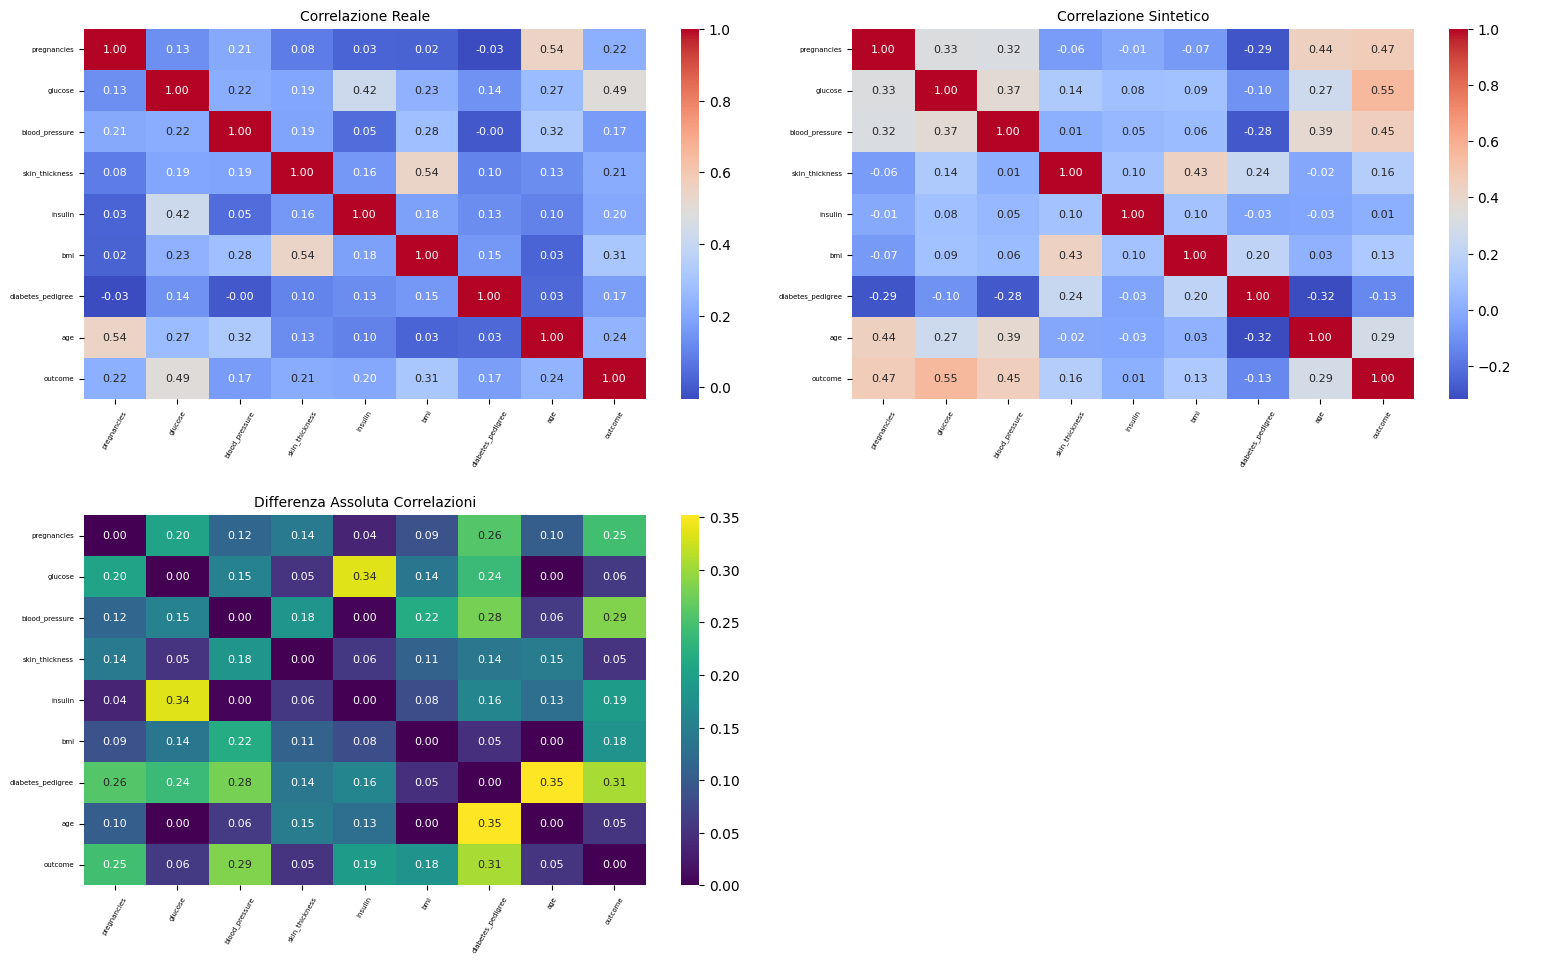

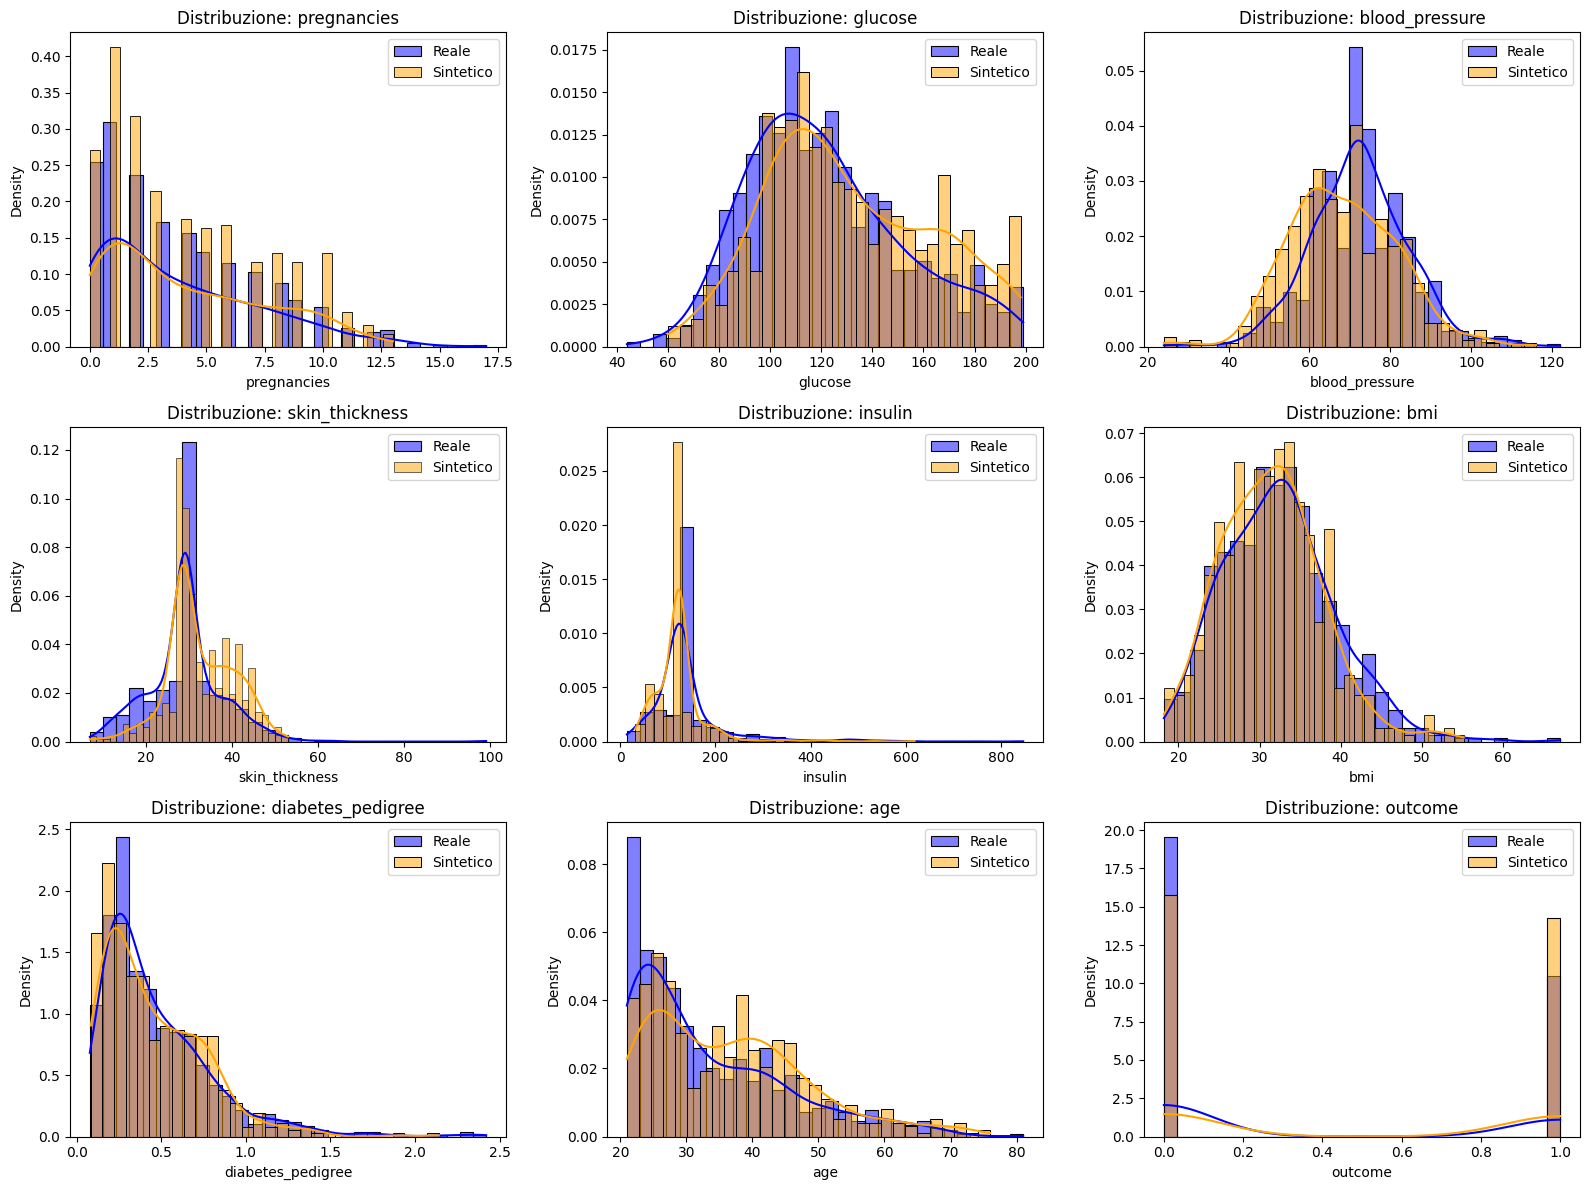


===== ANALISI SOMIGLIANZA STATISTICA: PRIVACY MODERATA =====

Confronto delle medie tra reale e sintetico:
Feature                         Mean Real   Mean Synthetic         Diff
pregnancies                        3.8451           6.9573       3.1123
glucose                          121.6562         140.4279      18.7717
blood_pressure                    72.3867          81.0150       8.6283
skin_thickness                    29.1081          33.3211       4.2130
insulin                          140.6719         144.0074       3.3355
bmi                               32.4552          29.3294      -3.1258
diabetes_pedigree                  0.4719           0.4821       0.0103
age                               33.2409          39.5467       6.3058
outcome                            0.3490           0.5009       0.1520

Confronto MATRICE DI CORRELAZIONE:


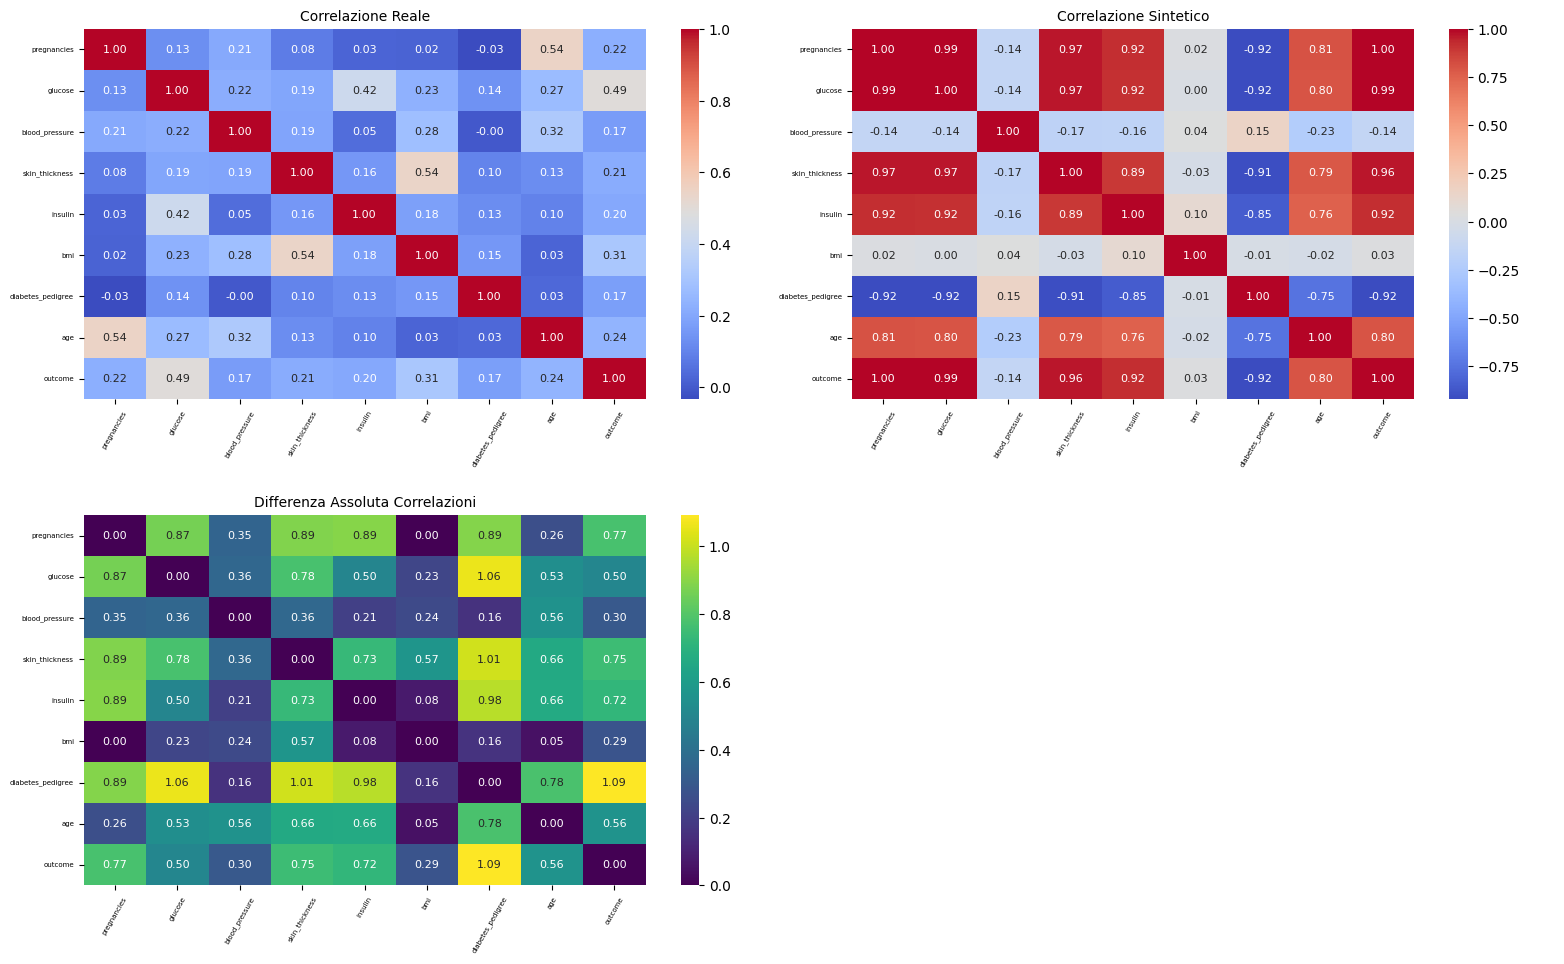

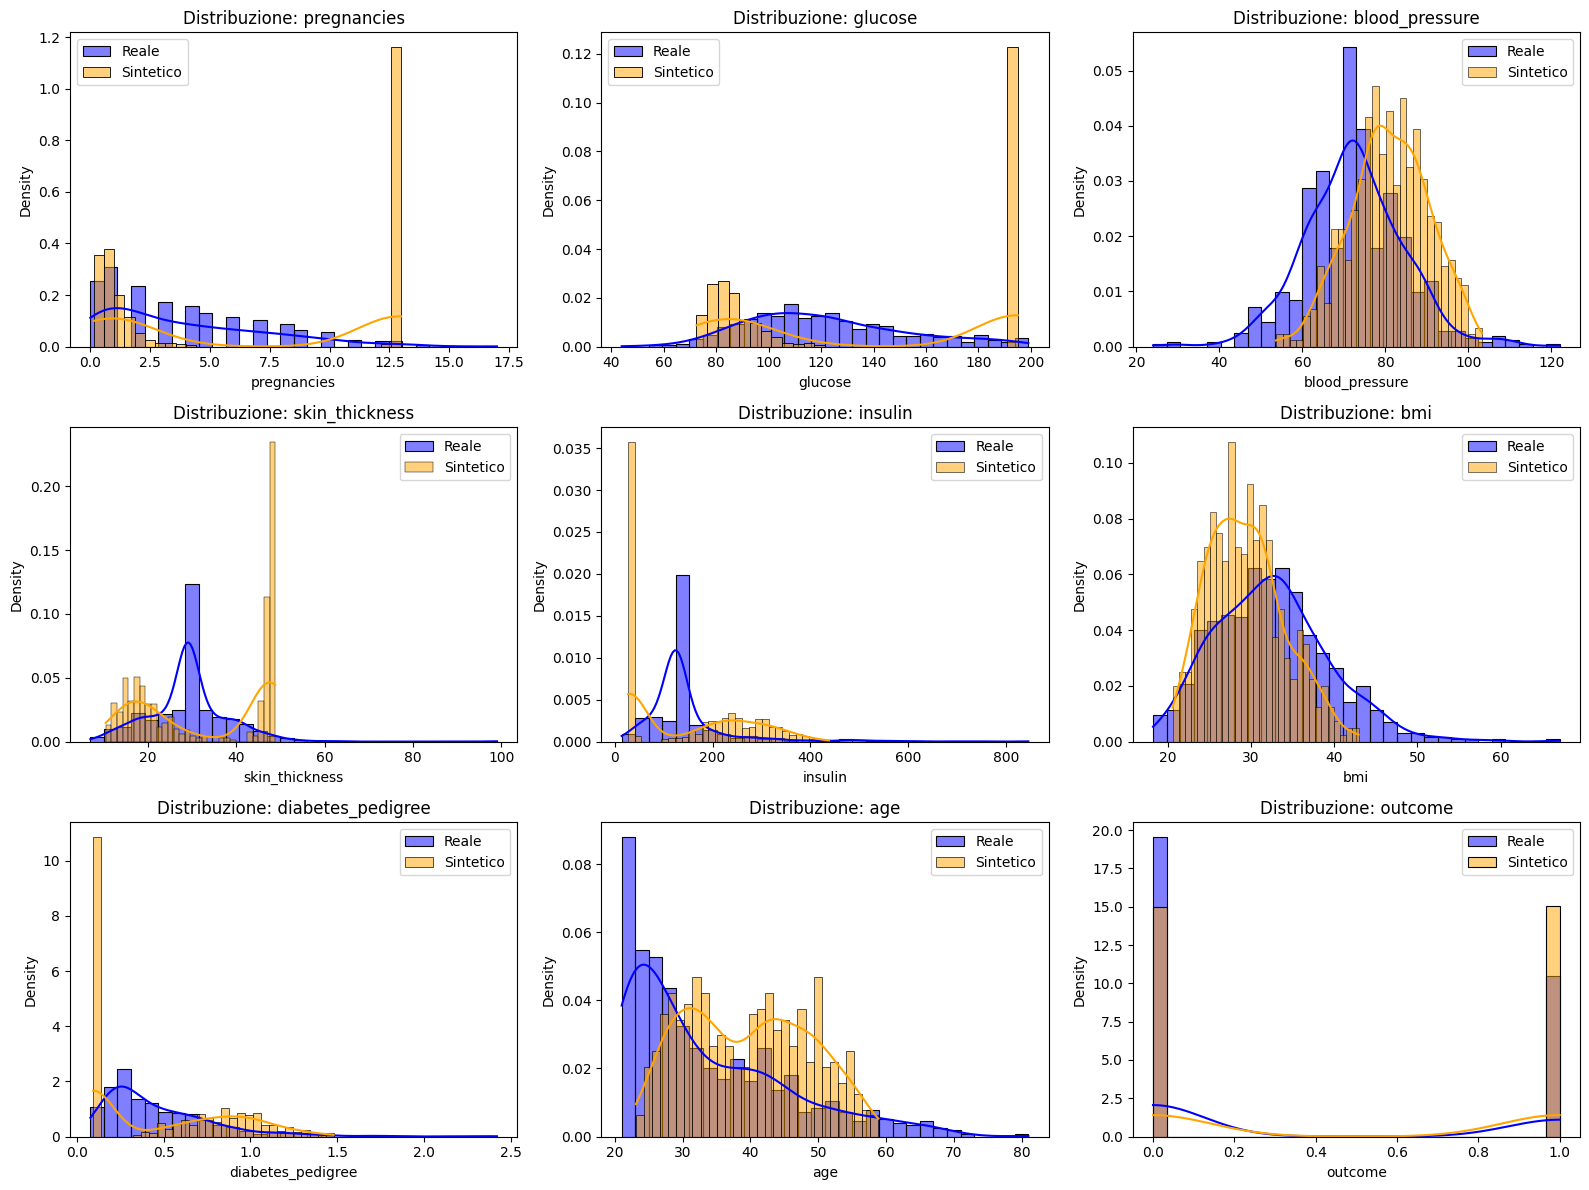


===== ANALISI SOMIGLIANZA STATISTICA: PRIVACY STRONG =====

Confronto delle medie tra reale e sintetico:
Feature                         Mean Real   Mean Synthetic         Diff
pregnancies                        3.8451           1.9128      -1.9323
glucose                          121.6562          82.2731     -39.3831
blood_pressure                    72.3867          94.5859      22.1991
skin_thickness                    29.1081          13.1111     -15.9970
insulin                          140.6719         214.1949      73.5231
bmi                               32.4552          28.3020      -4.1532
diabetes_pedigree                  0.4719           1.1213       0.6495
age                               33.2409          50.7170      17.4761
outcome                            0.3490           0.5009       0.1520

Confronto MATRICE DI CORRELAZIONE:


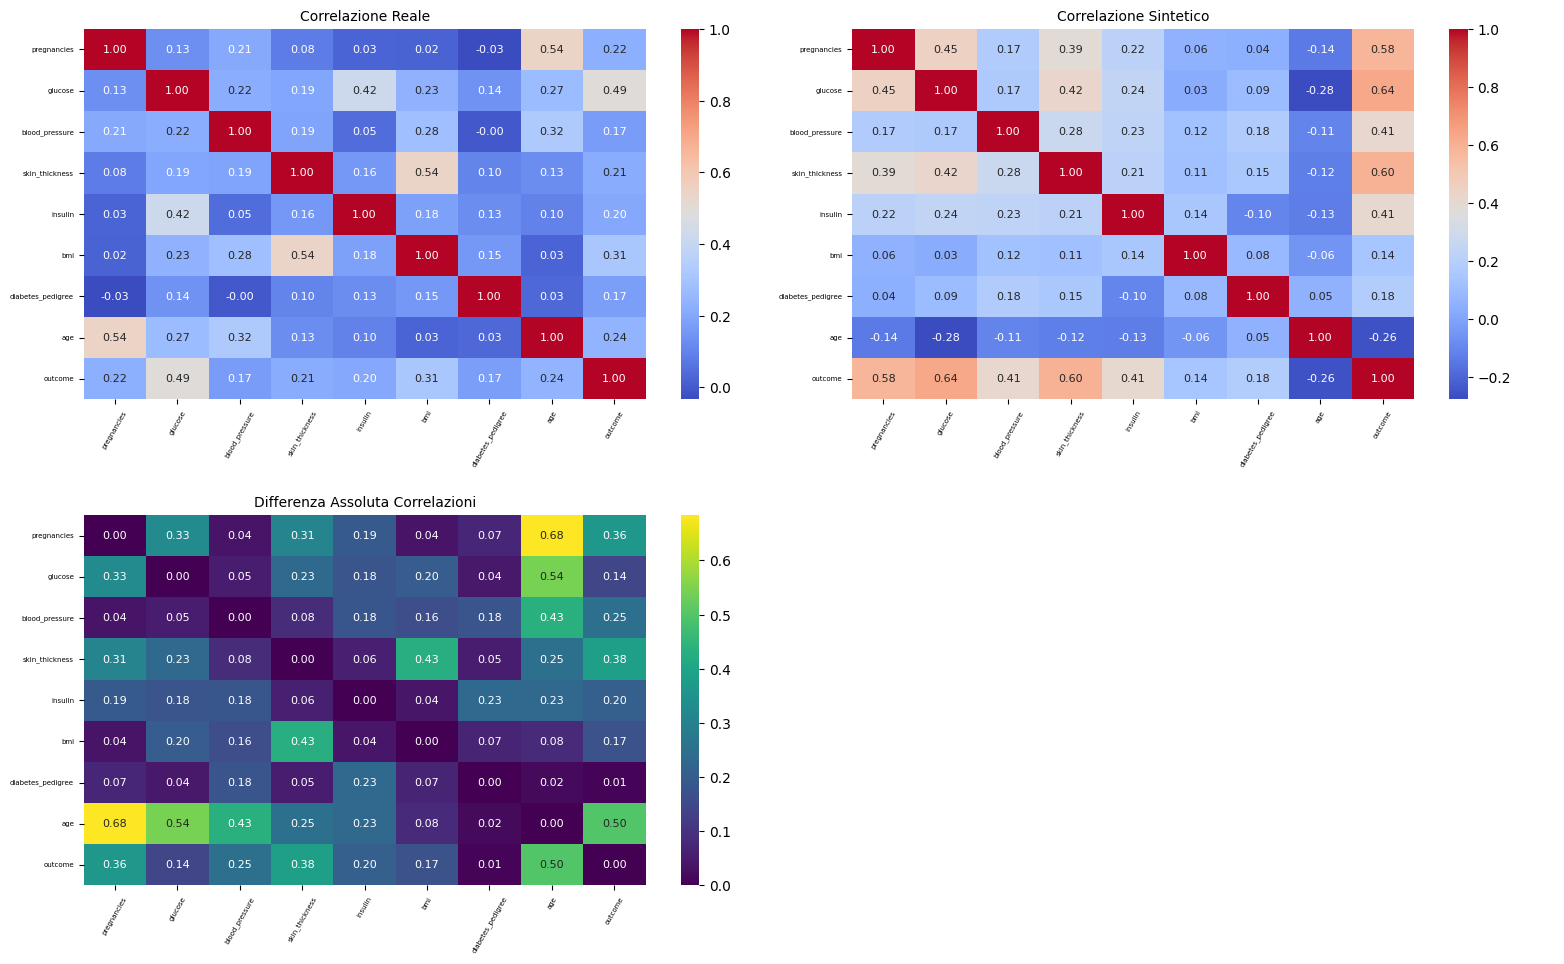

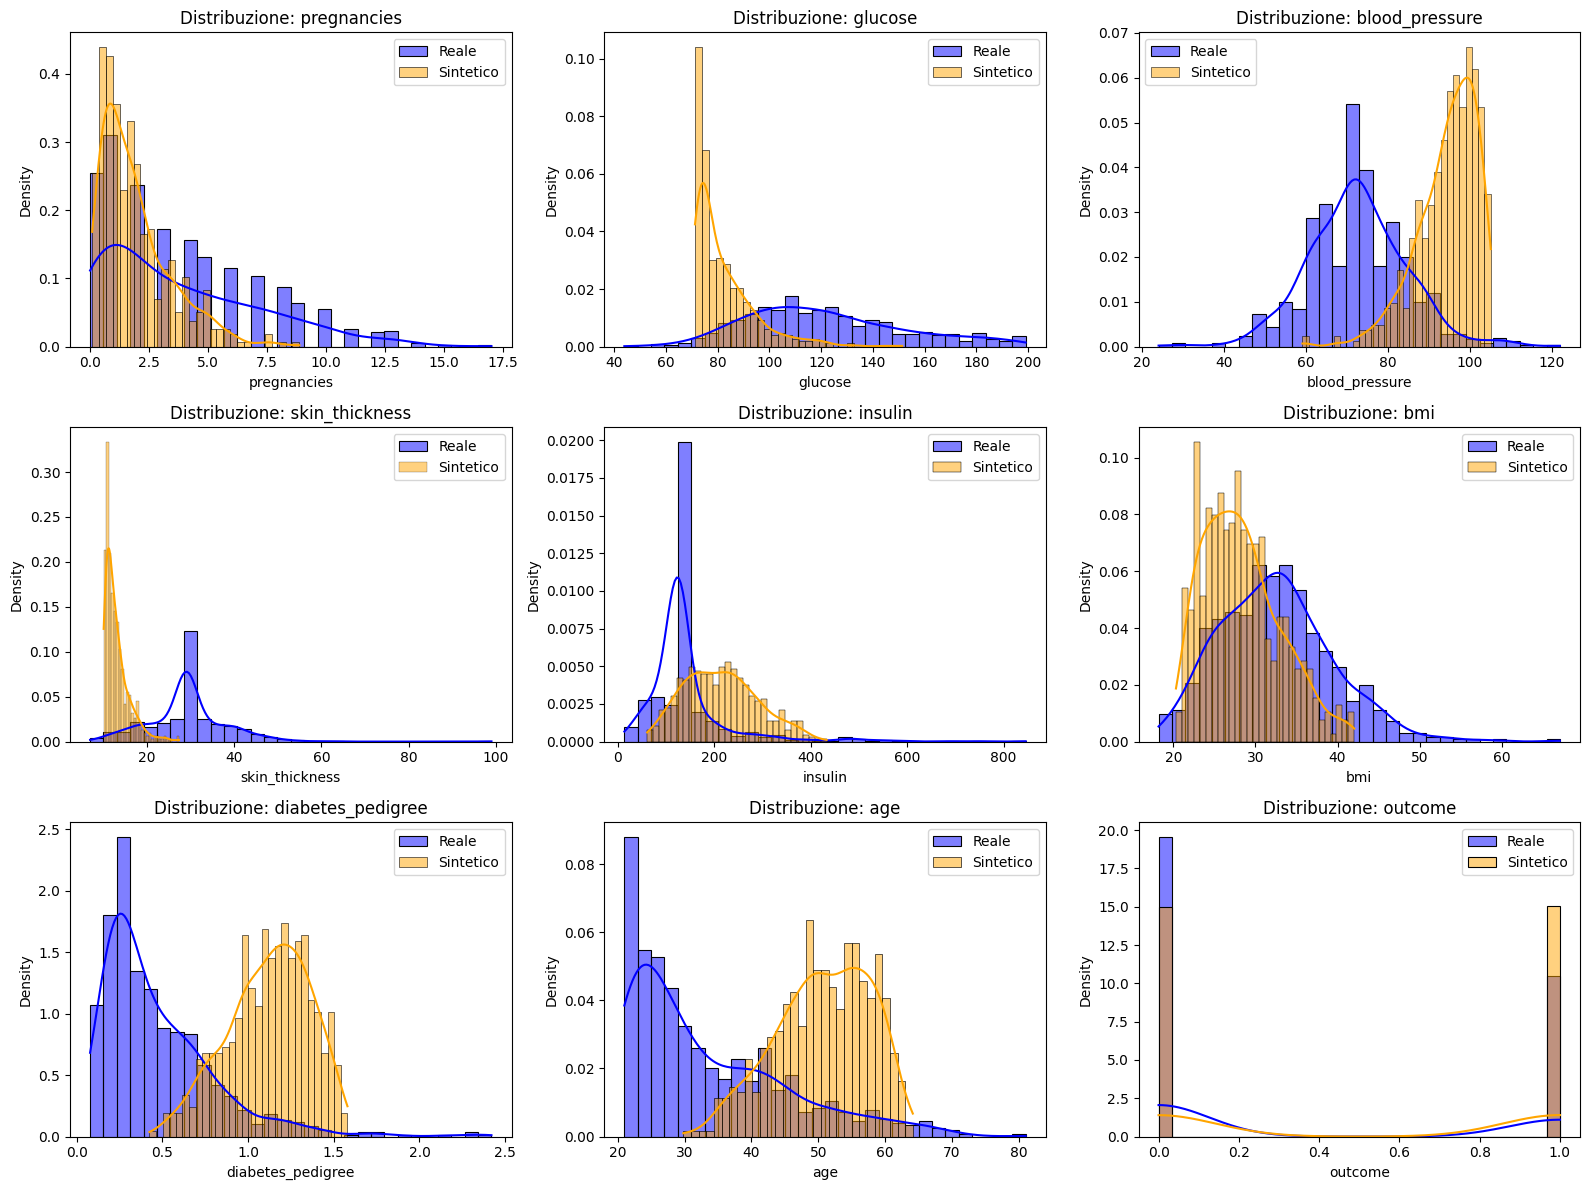

In [39]:
def somiglianza_statistica(real, synth, metadata, nome=""):
    print(f"\n===== ANALISI SOMIGLIANZA STATISTICA: {nome} =====")

    num_cols = [col for col in real.columns if pd.api.types.is_numeric_dtype(real[col])]

    print("\nConfronto delle medie tra reale e sintetico:")
    print("{:<28} {:>12} {:>16} {:>12}".format('Feature', 'Mean Real', 'Mean Synthetic', 'Diff'))
    for col in num_cols:
        mean_real = real[col].mean()
        mean_synth = synth[col].mean()
        diff = mean_synth - mean_real
        print("{:<28} {:>12.4f} {:>16.4f} {:>12.4f}".format(col, mean_real, mean_synth, diff))

    # 2. Confronto MATRICE DI CORRELAZIONE
    print("\nConfronto MATRICE DI CORRELAZIONE:")
    real_corr = real[num_cols].corr()
    synth_corr = synth[num_cols].corr()
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    # Prima riga:
    sns.heatmap(real_corr, ax=axes[0, 0], cmap='coolwarm', annot=True, fmt='.2f', annot_kws={"size":8})
    axes[0, 0].set_title('Correlazione Reale', fontsize=10)
    axes[0, 0].tick_params(axis='x', labelsize=5, rotation=60)
    axes[0, 0].tick_params(axis='y', labelsize=5)
    sns.heatmap(synth_corr, ax=axes[0, 1], cmap='coolwarm', annot=True, fmt='.2f', annot_kws={"size":8})
    axes[0, 1].set_title('Correlazione Sintetico', fontsize=10)
    axes[0, 1].tick_params(axis='x', labelsize=5, rotation=60)
    axes[0, 1].tick_params(axis='y', labelsize=5)
    # Seconda riga:
    axes[1, 1].axis('off')
    sns.heatmap(abs(real_corr - synth_corr), ax=axes[1, 0], cmap='viridis', annot=True, fmt='.2f', annot_kws={"size":8})
    axes[1, 0].set_title('Differenza Assoluta Correlazioni', fontsize=10)
    axes[1, 0].tick_params(axis='x', labelsize=5, rotation=60)
    axes[1, 0].tick_params(axis='y', labelsize=5)
    plt.tight_layout(pad=2)
    plt.show()

    # 3. Confronto DISTRIBUZIONI
    num_per_row = 3
    num_cols_total = len(num_cols)
    num_rows = int(np.ceil(num_cols_total / num_per_row))
    fig_width = 16
    fig_height = 4 * num_rows
    fig, axes = plt.subplots(num_rows, num_per_row, figsize=(fig_width, fig_height))
    axes = axes.flatten()
    for ax, col in zip(axes, num_cols):
        sns.histplot(real[col], color='blue', label='Reale', kde=True, stat="density", bins=30, alpha=0.5, ax=ax)
        sns.histplot(synth[col], color='orange', label='Sintetico', kde=True, stat="density", bins=30, alpha=0.5, ax=ax)
        ax.set_title(f'Distribuzione: {col}')
        ax.set_ylabel('Density')
        ax.set_xlabel(col)
        ax.legend()
    for ax in axes[len(num_cols):]:
        ax.set_visible(False)
    plt.tight_layout()
    plt.show()

datasets_sintetici = [
    ("NO PRIVACY", synthetic_noprivacy, metadata_noprivacy),
    ("PRIVACY MODERATA", synthetic_mod, metadata_mod),
    ("PRIVACY STRONG", synthetic_strong, metadata_strong)
]

for nome, synth_df, meta in datasets_sintetici:
    somiglianza_statistica(df, synth_df, meta, nome)


**VALUTARE UTILITA' PER LA RICERCA**: addestrare modelli di predizione delle malattie su dati sintetici e valutarli su un set reale di holdout

TRINING DEI MODELLI CON I DIVERSI DATASET SINTETICI GENERATI (NO PRIVACY, MODERATA, STRONG)

In [40]:
def train_and_save_xgboost(synthetic_df, privacy_label, model_params=None, target_col="outcome"):
    """
    Allena un modello XGBoost su un dataset sintetico e lo salva su disco.

    Args:
        synthetic_df: pd.DataFrame, dati sintetici da usare (features + target).
        privacy_label: str, etichetta privacy usata nel nome file ("noprivacy", "mod", "strong").
        model_params: dict, parametri opzionali per XGBClassifier.
        target_col: str, nome della colonna target (default: "outcome").

    Returns:
        Il modello allenato.
    """
    if model_params is None:
        # Parametri di default robusti
        model_params = dict(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.9,
            colsample_bytree=0.9,
            eval_metric="logloss",
            random_state=42
        )
    X = synthetic_df.drop(columns=[target_col])
    y = synthetic_df[target_col]
    model = XGBClassifier(**model_params)
    model.fit(X, y)
    filename = f'xgboost_model_{privacy_label}.pkl'
    joblib.dump(model, filename)
    print(f"Modello XGBoost addestrato e salvato: {filename}")
    return model

# Allena 3 modelli con diversi i dataset sintetici di input
print("Training modello con dataset NO PRIVACY...")
model_noprivacy = train_and_save_xgboost(synthetic_noprivacy, "noprivacy")
print("Training modello con dataset PRIVACY MODERATA...")
model_modprivacy = train_and_save_xgboost(synthetic_mod, "modprivacy")
print("Training modello con dataset PRIVACY STRONG...")
model_strongprivacy = train_and_save_xgboost(synthetic_strong, "strongprivacy")

Training modello con dataset NO PRIVACY...
Modello XGBoost addestrato e salvato: xgboost_model_noprivacy.pkl
Training modello con dataset PRIVACY MODERATA...
Modello XGBoost addestrato e salvato: xgboost_model_modprivacy.pkl
Training modello con dataset PRIVACY STRONG...
Modello XGBoost addestrato e salvato: xgboost_model_strongprivacy.pkl


TEST DEI MODELLI SU DATI REALI HOLDOUT

In [41]:
def test_xgboost_model(model, X_real, y_real, privacy_label):
    y_pred = model.predict(X_real)
    y_prob = model.predict_proba(X_real)[:, 1]
    print(f"\nPerformance del modello allenato su dati {privacy_label.upper()} e testato su Dataset Reale di Holdout")
    print("Accuracy:", accuracy_score(y_real, y_pred))
    print("ROC-AUC:", roc_auc_score(y_real, y_prob))
    print("\nClassification Report:")
    print(classification_report(y_real, y_pred))

# Separa feature e target nel dataset holdout (lo fai una sola volta)
X_real = holdout_df.drop(columns=["outcome"])
y_real = holdout_df["outcome"]

# Usa la funzione per tutti i modelli
print("Testing modello (allenato con dataset NO PRIVACY) su dati holdout...")
test_xgboost_model(model_noprivacy, X_real, y_real, "no privacy")
print("Testing modello (allenato con dataset PRIVACY MODERATA) su dati holdout...")
test_xgboost_model(model_modprivacy, X_real, y_real, "moderate privacy (ε=6.0)")
print("Testing modello (allenato con dataset PRIVACY STRONG) su dati holdout...")
test_xgboost_model(model_strongprivacy, X_real, y_real, "strong privacy (ε=2.0)")


Testing modello (allenato con dataset NO PRIVACY) su dati holdout...

Performance del modello allenato su dati NO PRIVACY e testato su Dataset Reale di Holdout
Accuracy: 0.696969696969697
ROC-AUC: 0.7446913580246913

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.74      0.76       150
           1       0.56      0.62      0.59        81

    accuracy                           0.70       231
   macro avg       0.67      0.68      0.67       231
weighted avg       0.70      0.70      0.70       231

Testing modello (allenato con dataset PRIVACY MODERATA) su dati holdout...

Performance del modello allenato su dati MODERATE PRIVACY (Ε=6.0) e testato su Dataset Reale di Holdout
Accuracy: 0.658008658008658
ROC-AUC: 0.6177366255144032

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.99      0.79       150
           1       0.75      0.04      0.07        81

    accur